In [1]:
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set()

In [3]:
a = 20 # parameter a of the beta prior
b = 10 # parameter b of the beta prior
theta = 0.25 # true unknown parameter, P(HEAD)
n = 100 # number of coin tosses. Try 5000!

In [4]:
#np.random.seed(42)
#y = np.random.binomial(n, theta) # random number of heads from the distribution from a binomial distribution
y = 24

# Exercise session 2: Beta-Binomial, Reporting, Gridding

Let us consider a coin that lands heads with probability $\theta=0.25$ (unknown to us). 

Our prior knowledge of $\theta$ is encoded in a Beta distribution (where "success" corresponds to the coin landing heads), with parameters $a=20$ and $b=10$:

$$ \theta \sim \rm{Beta}(a,b).$$

That is, the prior probability density function (pdf) of $\theta$ is:
$$f_{\rm prior}(\theta) = \frac{1}{B(a, b)} \theta^{a-1} (1-\theta)^{b-1},\qquad \theta \in (0, 1).$$


We toss the coin $n=100$ times and observe a number $y=24$ of heads. How does our belief of $\theta$ change with the measurement?

Note: If you need the Beta probability distribution $\rm Beta$ in Python, use `scipy.stats.beta`. If you need the beta function $B$ in Python, it is `scipy.special.beta`.

## 0: Probabilistic model

* Derive and comment the full probabilistic model.

The full probabilistic model is:

\begin{align}
\theta \sim \rm{Beta}(a,b)\\
y|\theta \sim \rm{Bin}(n, \theta).
\end{align}

It is the classic Beta-binomial model. The random variable $y$ represents the number of success (heads) events over $n$ trials. The success probability $\theta$ is constant in all flips, which are independent events. For a given value of $\theta$, the probability of observing $y$ heads in $n$ trials is a binomial. The prior of $\theta$ is a Beta with *fixed* coefficients $a$ and $b$.

The beta prior of $\theta$ is *conjugate* with the binomial likelihood, and thus the posterior of $\theta$ has a close-form beta structure.

## 1: Prior distribution


* Plot the probability density function (pdf) of the prior $f_{\rm prior}(\theta)$. Explain our prior belief on $\theta$ in words.

The pdf of the prior is:

$$ f_{\rm prior}(\theta) = \frac{1}{B(a,b)} \theta^{a-1} (1-\theta)^{b-1}, \qquad \theta \in (0, 1),$$

where $B(a,b)$ is the [beta function](https://en.wikipedia.org/wiki/Beta_function) returning the right normalization constant such that $\int_{0}^1 f_{\rm prior}(\theta) \; d \theta = 1.$ <br/> 

In [5]:
prior_var = stats.beta(a, b) # the .pdf method contains the probability density function

In [6]:
def prior_dist(theta, a=20, b=10):
    return 1/scipy.special.beta(a,b) * theta**(a-1) * (1-theta)**(b-1) 

In [7]:
assert(np.allclose(prior_var.pdf(0.5) , prior_dist(0.5))) # our implementation is close to scipy.stats

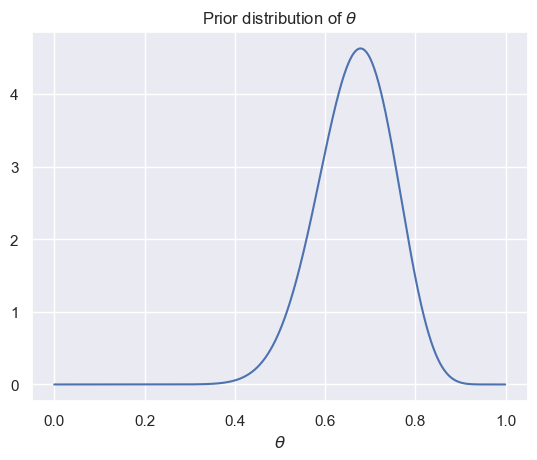

In [8]:
dtheta = 1e-3 # discretization step for theta
theta_vec = np.arange(0, 1, dtheta) # discretized theta range
plt.plot(theta_vec, prior_var.pdf(theta_vec))
plt.xlabel(r"$\theta$");
plt.title(r"Prior distribution of $\theta$");

According to our prior, the head outcome is more likely. This is in contrast with the underlying reality.

* Compute the mean, the mode, and the standard deviation of the prior distribution

In [9]:
# See formulas in the lecture notes "The beta-binomial model"
prior_mean = a/(a+b)
prior_mode = (a-1)/(a + b - 2)
prior_sd = np.sqrt(a*b/((a+b)**2*(a+b+1)))
prior_mean, prior_mode, prior_sd

(0.6666666666666666, 0.6785714285714286, 0.08466675133346033)

* Compute the 95\% Highest Density Interval (HDI) of the prior distribution. 

    Hints: 
    * The distribution is unimodal. See slide 10 in lecture notes "Reporting the results of a Bayesian analysis". 
    * Quantiles of a distribution are given by the `.ppf` method of a `scipy.stats` distribution

In [10]:
alpha = 0.05
L = prior_var.ppf(alpha/2)
H = prior_var.ppf(1-alpha/2) # ppf = percent point function
HDI = [L, H]
HDI

[0.4916766461900099, 0.8206163507648881]

* Verify through numerical integration that the interval above contains indeed approximately 95% of the distribution area

We want to verify that

$$\int_{L}^{H} f_{\rm prior}(\theta) \; d\theta = 0.95.$$

A multi-rectangle approximation of the integral above is implemented here

$$ \int_{L}^{H} f_{\rm prior}(\theta) \; d\theta = 0.95. \approx \Delta\theta \sum_i  f_{\rm prior}(\theta_i),$$

where the points $\theta_i$ are linerly spaced in the HDI interval with step $\Delta \theta$.

In [11]:
theta_int = np.linspace(L, H, 1000, endpoint=False)
dtheta_int = theta_int[1] - theta_int[0]
np.sum(prior_var.pdf(theta_int))*dtheta_int

0.9499550886432847

* Plot the prior distribution together with its mean, mode, and 95% HDI. Is the prior representative of the true value of $\theta$?

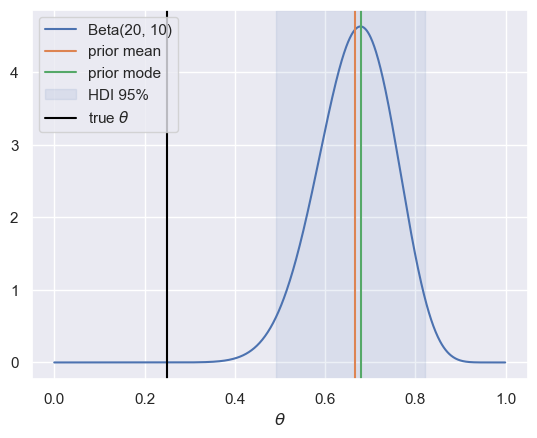

In [12]:
plt.plot(theta_vec, prior_var.pdf(theta_vec), color="C0", label="Beta(20, 10)")
plt.axvline(prior_mean, color="C1", label=r"prior mean")
plt.axvline(prior_mode, color="C2", label=r"prior mode")
plt.axvspan(xmin=L, xmax=H, alpha=0.1, color="C0", label=r"HDI 95%")
plt.axvline(theta, color="black", label=r"true $\theta$")
plt.legend()
plt.xlabel(r"$\theta$");

The prior is not very representative of the true $\theta$. The bulk of the prior distribution is completely off, and the prior assigns a very small densities to points close to the true value 0.25.

## 2: Posterior distribution - exact derivation

* Obtain the posterior distribution in closed form.

The Beta-binomial model:
\begin{align}
\theta &\sim \mathrm{Beta}(a,b)\\
y|\theta &\sim \mathrm{Bin}(n, \theta)
\end{align}
is **conjugate**. We have
$$\theta|y \sim \rm{Beta}(a+y, b + n - y)$$
Which means:
$$f_{\rm post}(\theta) = f(\theta | \beta) = \frac{1}{B(a+y,b+n-y)} \theta^{a+y-1} (1-\theta)^{b+n-y-1}, \qquad \theta \in (0, 1).$$

In [13]:
a_post = a + y
b_post = b + n - y
post_var = stats.beta(a=a_post, b=b_post)

* Plot the posterior distribution together with the prior and the true value of $\theta$. Comment on the result.

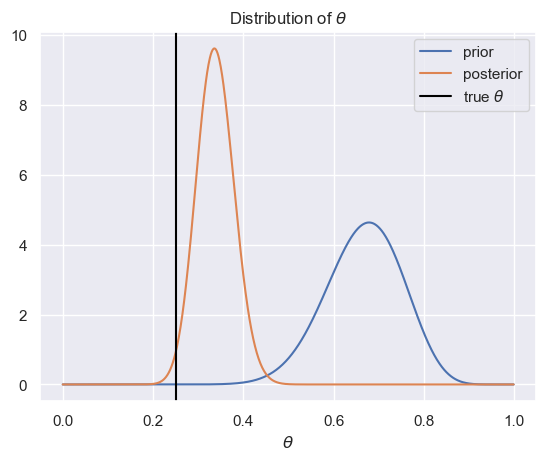

In [14]:
plt.plot(theta_vec, prior_var.pdf(theta_vec), label="prior")
plt.plot(theta_vec, post_var.pdf(theta_vec), label="posterior")
plt.axvline(theta, color="black", label=r"true $\theta$")
plt.legend()
plt.xlabel(r"$\theta$");
plt.title(r"Distribution of $\theta$");

The posterior $f(\theta | y)$ gets closer to the unknown true parameter $0.25$, despite the wrong prior assuption.

## 3: Likelihood

* Obtain a mathematical expression of the likelihood function $\mathcal{L}(\theta) = P(y=24|\theta)$

The likelihood function $\mathcal{L}(\theta)$ is:

$$\mathcal{L}(\theta) = P(y|\theta) = {{n}\choose{y}} \theta^{y} \cdot (1-\theta)^{n-y},$$
seen as a function of $\theta$, with $y$ fixed to the observed value. 


* Compute the likelihood function on a grid in [0,1]. You may disregard the multiplicative factor that does not depend on $\theta$.

In [15]:
def lik(theta):
    return (theta ** y) * (1 - theta)**(n-y)

lik_vec = lik(theta_vec)

In [16]:
def lik_exact(theta):
    return scipy.stats.binom.pmf(k=y, n=n, p=theta) # pmf = probability mass function

lik_vec_exact = lik_exact(theta_vec) # likelihood

* Plot the likelihood function. What do you notice?

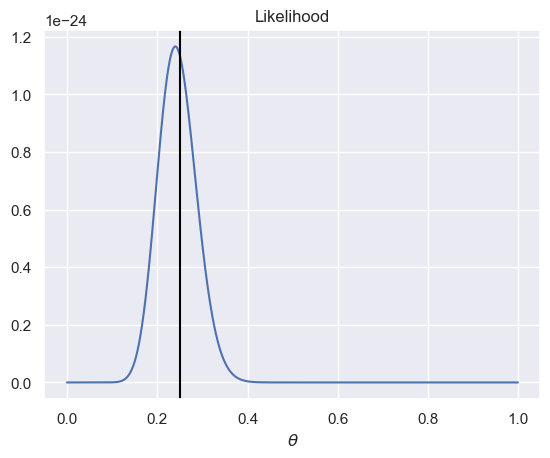

In [17]:
plt.plot(theta_vec, lik_vec)
#plt.axvline(theta_ml, color="red")
plt.axvline(theta, color="black", label=r"true $\theta$")
plt.xlabel(r"$\theta$");
plt.title("Likelihood");

* The maximum of the likelihood (maximum likelihood estimator) is a good point estimate for $\theta$.

* The likelihood function has a very bad numerical scale ($10^{-24}$), and it gets worse and worse for increasing values of $n$. In this case it still works (it falls within the float64 range), but we are close to the limit and risk *numerical underflow*. In practice, we often work with the *logarithm* of the likelihood (and related quantities) to circumvent these numerical issues.

## 3. Point estimates

* Obtain the maximum likelihood (ML) point estimate $\theta^{\rm ml}$.

Hint: $\theta^{\rm ml}$ is the value of $\theta$ corresponding to the maximum of the likelihood function $\mathcal{L}(\theta)$

In [18]:
theta_ml = theta_vec[np.argmax(lik_vec)] # the gridding way
# theta_ml = y/n (can also be computed in closed-form!)
# theta_ml = scipy.optimize.minimize(lambda theta: -1e24*lik(theta), x0=0.5)

* Obtain the maximum a posteriori (MAP) point estimate

Hint: $\theta^{\rm MAP}$ is the value of $\theta$ corresponding to the maximum of the posterior density $f_{\rm post }(\theta)$.

In [19]:
theta_map = (a_post-1)/(a_post+b_post-2); theta_map # analytical solution

0.3359375

In general, we may need to obtain it with a numerical approach.

In [20]:
# theta_map = theta_vec[np.argmax(post_dist.pdf(theta_vec))] # numerical solution (gridding)
# theta_map = scipy.optimize.minimize(lambda theta: -post_dist.pdf(theta), x0=0.5) # numerical solution (optimization)

* Obtain the posterior mean point estimate $E[\theta|y]$

In [21]:
theta_mean = (a_post)/(a_post+b_post); theta_mean # analytical solution 

0.3384615384615385

More in general, we could get a numerical approximation. By definition, we have:

$$E[\theta|y] = \int_{0}^1 \theta f_{\rm post}(\theta)\; d\theta.$$

The integral above can be approximated numerically as:

In [22]:
np.sum(theta_vec * post_var.pdf(theta_vec)) * dtheta # numerical solution (integration)

0.3384615384615385

## 4: Posterior distribution - gridding, aka brute-force approximation

* Obtain a numerical approximation of the posterior $f_{\rm post}(\theta)$, by normalizing the product $\mathcal{L}(\theta) \cdot f_{\rm prior}(\theta)$

By definition, the posterior distribution $f_{\rm post}(\theta)$ is:
$$f_{\rm post}(\theta) = f(\theta | y) = \frac{\overbrace{P(y|\theta)}^{=\mathcal{L}(\theta)} \cdot f_{\rm prior}(\theta)}{P(y)},$$
where $P(y) = \int{P(y|\theta)\; d\theta}$.

Thus, $f_{\rm post}(\theta)$ corresponds to the product $\mathcal{L}(\theta) \cdot f_{\rm prior}(\theta)$, up to a multiplicative constant to be determined.

We have:
$$f_{\rm post}(\theta) = \frac{1}{Z} \cdot \mathcal{L}(\theta) f_{\rm prior}(\theta),$$

where the normalization constant $Z$ must be chosen to satisfy:

$$\int_\theta f_{\rm post}(\theta) \; d\theta = 1,$$
thus

$$Z = \int_\theta \mathcal{L}(\theta) f_{\rm prior}(\theta) \; d\theta = 1.$$

Any numerical integration method can be used to approximate the integral above. Easiest choice: Riemann sum on a uniform grid, with step size $\Delta \theta$
$$ Z \approx \Delta \theta \sum_{i} \mathcal{L}(\theta_i) f_{\rm prior}(\theta_i)$$

In [23]:
p_theta_post = lik_vec * prior_var.pdf(theta_vec)
Z = (np.sum(p_theta_post) * dtheta)
p_theta_post = p_theta_post/Z

**NOTE**: The Beta-Binomial case is a very special and lucky (conjugate) combination where we can compute $f_{\rm post}(\theta)$ analytically. The gridding approach above is also applicable to non-conjugate prior/likelihood combination. However, it is only feasible in 1-3 dimensions  (curse of dimensionality!). For non-conjugate prior/likelihood combinations in higher dimensions, more advanced methods are needed. See following lectures!

* Verify that the numerical approximation of the posterior is accurate

In [24]:
np.allclose(p_theta_post, post_var.pdf(theta_vec))

True

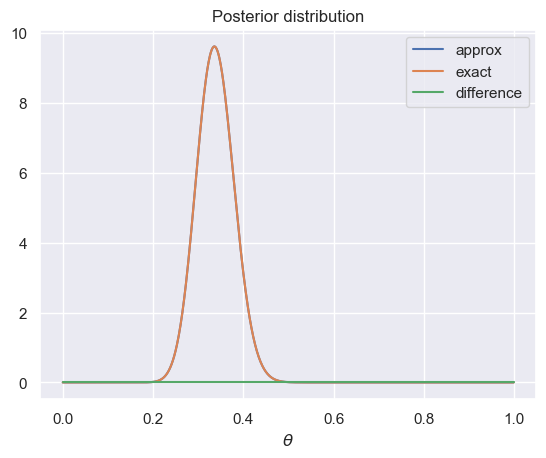

In [25]:
plt.plot(theta_vec, p_theta_post, label="approx")
plt.plot(theta_vec, post_var.pdf(theta_vec), label="exact")
plt.plot(theta_vec, p_theta_post - post_var.pdf(theta_vec), label="difference")
plt.xlabel(r"$\theta$");
plt.legend()
plt.title("Posterior distribution");

The numerical approximation is indeed accurate

* Obtain a scaled version of the likelihood function $\mathcal{L}(\theta)$, such that $\int_{0}^{1} \mathcal{L}(\theta)\; d\theta = 1$ and plot it. What does this function represent?

In [26]:
lik_vec_scaled = lik_vec/((np.sum(lik_vec) * dtheta))

The scaled likelihood may be seen as the posterior for a flat prior over $[0, 1]$. Such a flat prior is equivalent to a $\rm{Beta}(a=1,b=1).$

* Plot the posterior, the prior, and the scaled likelihood on the same axes. Comment the result.

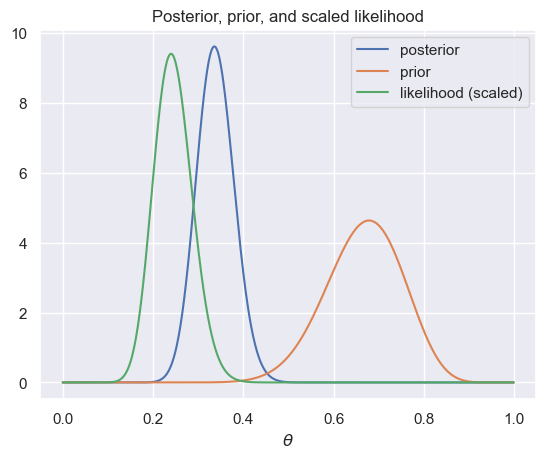

In [27]:
plt.plot(theta_vec, post_var.pdf(theta_vec), label="posterior")
plt.plot(theta_vec, prior_var.pdf(theta_vec), label="prior")
plt.plot(theta_vec, lik_vec_scaled, label="likelihood (scaled)")


plt.xlabel(r"$\theta$");
plt.legend()
plt.title("Posterior, prior, and scaled likelihood");

The posterior seems to be a trade-off between the prior (which pushes towards high values of $\theta$) and the scaled likelihood (which pushes towards lower values). Increasing the number of draws, the weight of the likelihood increases (the prior is overwhelmed by the posterior).

* Try to execute the code above with a larger value of n (ex. n = 5000). What happens? Why?

The numerical approximation of the likelihood/posterior fails due to numerical underflow.

## Enter the logarithm: log-likelihood and log-posterior

To avoid numerical difficulties, we may instead compute the *logarithm* of the likelihood and the posterior density. Starting from the definition:

$$f_{\rm post}(\theta) = f(\theta | y) = \frac{{P(y|\theta)} \cdot f_{\rm prior}(\theta)}{P(y)},$$

we obtain the following formula for the log-posterior $\log f_{\rm post}(\theta)$:
$$\log f_{\rm post}(\theta) = \overbrace{\log P(y|\theta)}^{=\ell(\theta)} + \log f_{\rm prior}(\theta) + \log P(y)$$

Let us compute the *log-likelihood* $\ell(\theta)$:

$$\ell(\theta) = \log \mathcal{L}(\theta) = \log P(y|\theta) = 
\log {{n}\choose{y}} \theta^{y} (1-\theta)^{(n-y)}=\log{{n}\choose{y}} + y \log \theta + (n-y) \log (1-\theta)$$

* Evaluate and plot the log-likelihood $\ell(\theta)$ up to an additive constant over a grid

In [28]:
def log_lik(theta):
    theta = np.where(theta==0, 1e-12, theta) # avoids a numerical issue for theta=0
    theta = np.where(theta==1, 1-1e-12, theta) # avoids a numerical issue for theta=1
    return y*np.log(theta)  + (n-y)*np.log(1 - theta)

log_lik_vec = log_lik(theta_vec) # log-likelihood, up to a constant additive factor

* Plot the log-likelihood and comment the results

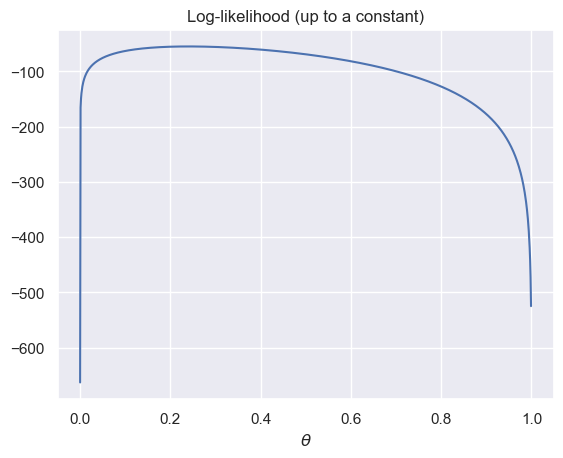

In [29]:
plt.plot(theta_vec, log_lik_vec)
plt.xlabel(r"$\theta$");
plt.title("Log-likelihood (up to a constant)");

* Evaluate the log-prior $\log f_{\rm prior}(\theta)$ up to an arbitrary additive constant over a grid

$$\log f_{\rm prior}(\theta) = \frac{1}{{B}(a,b)} \theta ^{a-1} (1-\theta)^{b-1} = 
- \log {B}(a, b) + (a-1)\log \beta + (b-1) \log (1-\beta)
$$

In [30]:
def log_prior(theta):
    theta = np.where(theta==0, 1e-12, theta) # avoids a numerical issue for theta=0
    theta = np.where(theta==1, 1-1e-12, theta) # avoids a numerical issue for theta=1
    return (a-1) * np.log(theta) + (b-1) * np.log(1-theta)

In [31]:
log_prior_vec = log_prior(theta_vec) # or use logprior fron scipy.stats
#log_prior_vec = prior_var.logpdf(theta_vec) # or derive it analytically...

* Evaluate the log-posterior $\log f(\theta | y)$ up to an additive constant over a grid

$$\log f(\theta | y) = \overbrace{\log P(y|\theta)}^{=\ell(\theta)} + \log f_{\rm prior}(\theta) + \log P(y)$$

In [32]:
log_post_vec = log_prior_vec + log_lik_vec # again, up to an additive constant

* Plot the log-prior, log-likelihood, and log-posterior

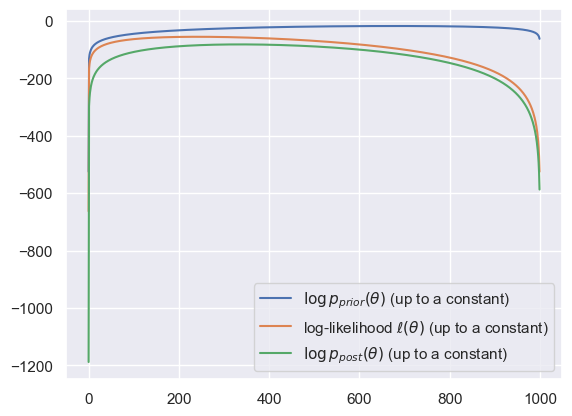

In [33]:
plt.plot(log_prior_vec, label=r"$\log p_{prior}(\theta)$ (up to a constant)")
plt.plot(log_lik_vec, label=r"log-likelihood $\ell(\theta)$ (up to a constant)")
plt.plot(log_post_vec, label=r"$\log p_{post}(\theta)$ (up to a constant)")
plt.legend();

* Obtain the normalized posterior $f(\theta|y)$ starting from the unnormalized log-posterior

In the variable `log_post_vec` we have a numerical value for $\log f_{\rm post}(\theta)$, up to an *additive* constant. Thus, in principle, `np.exp(log_post_vec)` we would have the posterior, up to a *multiplicative* constant.


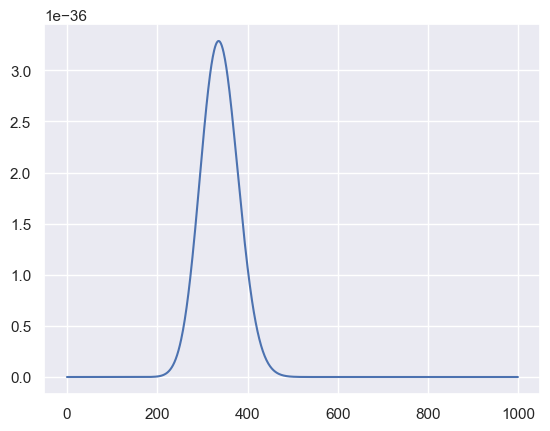

In [34]:
plt.plot(np.exp(log_post_vec));

This again may fail! Problems: numbers are too small! (for $n=5000$, $\approx e^{-2000}$, below machine epsilon). 



We can choose a better additive constant for the log-likelihood:

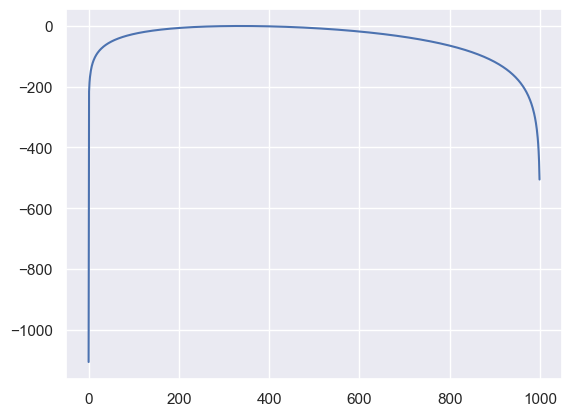

In [35]:
log_post_scaled = log_post_vec - np.max(log_post_vec)
plt.plot(log_post_scaled);

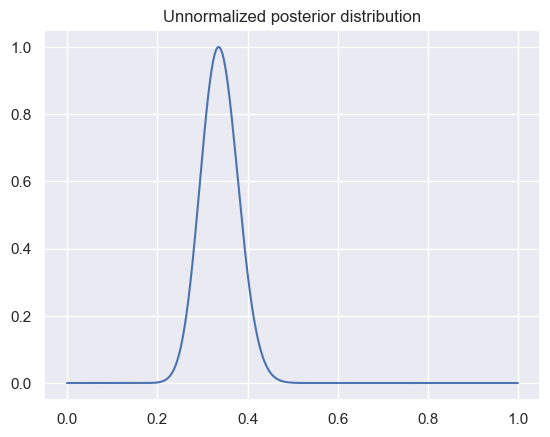

In [36]:
plt.title("Unnormalized posterior distribution")
plt.plot(theta_vec, np.exp(log_post_scaled));

Now it works! The maximum of the exponentiated function is $e^{0} = 1$. Now we just need to normalize it to be a probability distribution, which integrates to 1

In [37]:
post_unnorm = np.exp(log_post_scaled)
Z = np.sum(post_unnorm)*dtheta
post_norm = post_unnorm/Z

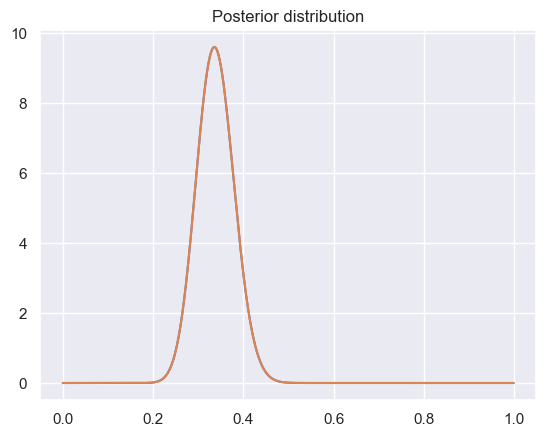

In [38]:
plt.title("Posterior distribution")
plt.plot(theta_vec, post_norm, label="Normalized")
plt.plot(theta_vec, post_var.pdf(theta_vec), label="Exact");

### Alternative implementation using the logsumexp

In the previous implementation, we have added the constant ``-np.max(log_post)`` to the log-posterior for numerical reasons. Then we normalized the posterior to sum up to 1. 

There is another "magic" normalization constant that help us achieve the same result even more easily:

In [39]:
LSE = scipy.special.logsumexp(log_post_vec)
post_norm_ = np.exp(log_post_vec - LSE)

In [40]:
np.sum(post_norm_)

1.0000000000000009

The logsumexp function, applied to the array of log-probabilities ``log_post_vec``, return a constant LSE such that
``np.sum(np.exp(log_post_vec - LSE)) = 1``. We are almost there: we would like the *integral* to be one, thus:

In [41]:
post_norm = np.exp(log_post_vec - LSE)/dtheta

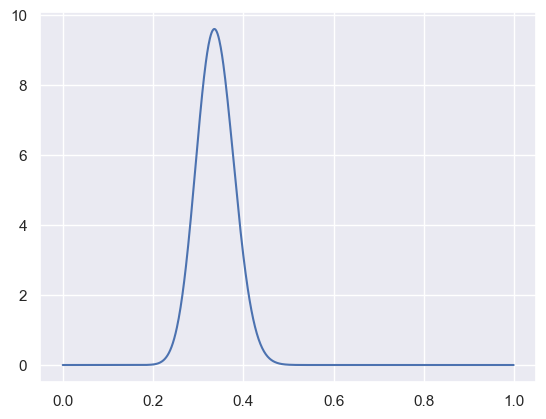

In [42]:
plt.plot(theta_vec, post_norm);

We have found a *magic constant* that provides a good scaling and the right normalization constant in one shot! How does it work?

## The logsumexp magic

Let us denote as $\tilde g(\theta)$ the log-posterior up to an additive constant $K$:

$$ \tilde g(\theta) = \log f_{\rm post}(\theta) + K \Rightarrow f_{\rm post}(\theta) = \frac{1}{Z} e^{\tilde g(\theta)}.$$

The constant $Z$ is such that $Z e^{\tilde g(\theta)}$ integrates to 1. Then,

$$ f_{\rm post}(\theta) = \frac{e^{\tilde g(\theta)}}{ \int{e^{\tilde g(\theta_i)}}\; d\theta}
\approx  \frac{e^{\tilde g(\theta)}}{\Delta \theta \sum_i{e^{\tilde g(\theta_i)}}} = 
\frac{e^{\tilde g(\theta)}}{\Delta \theta e^{\log \sum_i{e^{\tilde g(\theta_i)}}}} = \frac{1}{\Delta \theta} \frac{e^{\tilde g(\theta)}}{e^{\rm logsumexp(G)}} = \frac{1}{\Delta \theta}  e^{\tilde g(\theta) - \mathrm{logsumexp}(G)},$$
where $\mathrm{G} = [\tilde g(\theta_0), \tilde g(\theta_1), \dots, \tilde g(\theta_{n-1})]$ is the vector of the samples of $\tilde g$ at the grid points used for numerical integration of $\theta$.



* Internally, the logsumexp function avoid exponentiation with very small/very large numbers exploiting the identity:

$$ {\rm logsumexp}(x) = \log \sum_i e^{x_i} = c + \log \sum_i e^{(x_i - c)}.$$

* A robust implementation of logsumexp sets $c = \max(x_0, \dots, x_{n-1})$. This ensures that the largest exponentiated term is always $e^0=1$!


In [43]:
def logsumexp(x):
    c = x.max()
    return c + np.log(np.sum(np.exp(x - c)))


The logsumexp function is defined for a vector $\mathrm{x} = [x_0\; x_1\; \dots \; x_{n-1}]^\top$ as:

$$\mathrm{logsumexp}(\mathrm{x}) = \log \sum_i e^{x_i}.$$

Consider the following code:

* Whenever we have a summation in the original probability/likelihood domain, we can alternatively perform a logsumexp operation in the log-probability/log-likelihood domain. 

* Imagine we have a vector $x$ of log-probabilities and want to compute the sum of the probabilities. We have:
$$\sum_{i} e^{x_i}
% = \log e^{\overbrace{\log \sum_{i} e^{x_i}}^{= {\rm logsumexp}(x)}} 
= e^{{\rm logsumexp}(x)}.
%\log \left(\sum_{i} e^{x_i}\right) 
% = \log e^{\overbrace{\log \sum_{i} e^{x_i}}^{= {\rm logsumexp}(x)}} 
%= {{\rm logsumexp}(x)}.
$$

    * If the probabilities $e^{x_i}$ are small (i.e., $x_i$ are negative values with a large modulus), direct evaluation of the left-hand side may fail and the logsumexp implementation at the right-hand side is to be preferred. 
    
    * If we are interested in a result in the log-domain, the exponentiation at the right-hand side (which could also be problematic) is avoided.

* In general, it is suggested to perform as many operations as possible in the log-domain and go back to the original domain only when it is strictly necessary (and numerically safe!)